# SN Global

This notebook is a detailed work through showing how the Signal-to-Noise is calulcated. The methods outlined below are by no means as the final method used, but are just to show working

This notebook contains:
* First analysis of SN on global level.
* Sample plots prooving the S/N method works.
* Plots useful for presentations outlining how the method works.


# Preamble

In [80]:
import numpy as np
import os
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import xarray as xr
from importlib import reload
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from dask.diagnostics import ProgressBar

In [81]:
import sys
import constants
sys.path.append(constants.MODULE_DIR)
import xarray_class_accessors as xca
import signal_to_noise
import sn_plotting 
from classes import ExperimentTypes
import open_ds
from utils import pprint_list
from warnings import filterwarnings
filterwarnings('ignore')
import utils

In [82]:
# The directory where all of the longrun mip data used in this notebook is stored.
variable = 'tas'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable, 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped'

In [83]:
IMG_DIR = constants.IMAGE_SAVE_DIR_TOP_LEVEL
notebook_number ='01'
model = 'CCSM3'

In [84]:
WINDOW = constants.WINDOWS_OF_INTEREST[1]
WINDOW

80

In [85]:
# Set-up logging for notebook
logger = utils.get_notebook_logger()
utils.change_logging_level('DEBUG')

In [86]:
logger.debug('Test')

- Test


# Control
THe SN for the piControl is get the stable/unstable bounds for each gridcell. This is to work out what can be considered natural variabilbity of the system.

In [87]:
pprint_list(os.listdir(ROOT_DIR), num_start_items=3)

lenght = 32
 0. tas_ann_HadGEM2_control_239_g025.nc
 1. tas_mon_HadCM3L_control_1000_g025.nc
 2. tas_mon_GFDLCM3_control_5200_g025.nc


In [88]:
models = constants.LONGRUNMIP_MODELS
model = 'ipslcm5a'

model_files = [f for f in os.listdir(ROOT_DIR) if ('control' in f or 'abrupt4x' in f) and model in f.lower()]
control_fname = str([f for f in model_files if 'control' in f][0])
abrupt_fname = str([f for f in model_files if 'abrupt' in f][0])
print(control_fname, abrupt_fname, sep=', ')

tas_mon_IPSLCM5A_control_1000_g025.nc, tas_mon_IPSLCM5A_abrupt4x_1000_g025.nc


In [89]:
control = xr.open_dataset(os.path.join(ROOT_DIR, control_fname), use_cftime=True).tas
abrupt = xr.open_dataset(os.path.join(ROOT_DIR,abrupt_fname), use_cftime=True).tas

In [90]:
control

<xarray.DataArray 'tas' (time: 1000, lat: 72, lon: 144)>
[10368000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    height   float64 ...

In [91]:
abrupt 

<xarray.DataArray 'tas' (time: 1000, lat: 72, lon: 144)>
[10368000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1000-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    height   float64 ...

In [92]:
reload(xca)
reload(signal_to_noise)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/modules/signal_to_noise.py'>

In [93]:
# Anomalias
control_anom = control.clima.anomalies()

# Global Mean (space mean)
control_anom_smean = control_anom.clima.space_mean()
control_anom_smean = control_anom_smean.isel(time=slice(12,None)) # TODO: First part is bugged

# Signal
control_anom_smean_signal = control_anom_smean.sn.calculate_rolling_signal(window = WINDOW, 
                                                                           logginglevel='DEBUG')

# Lowess filter
control_anom_smean_loess = control_anom_smean.sn.apply_loess_filter(window=WINDOW)

# Noise
control_anom_smean_noise = control_anom_smean_loess.sn.calculate_rolling_noise(window=WINDOW, 
                                                                           logginglevel='DEBUG')

# The signal to noise for the control anomlaies.
control_anom_smean_sn = control_anom_smean_signal/control_anom_smean_noise

lbound, ubound =\
            signal_to_noise.calculate_upper_and_lower_bounds(control_anom_smean_sn, 
                                                                           logginglevel='DEBUG')

- Calculting the rolling signal
- Adjusting time points by 39
- Calculting the rolling noise
- Adjusting time points by 39
- Calculating Upper and lower control bounds
- np.nanpercentile used
- [-1.77056398]  - [2.03147244]


In [127]:
# Anomalis
abrupt_anom = abrupt.clima.anomalies(historical=control)

# Globab mean
abrupt_anom_smean = abrupt_anom.clima.space_mean()

# Signal
abrupt_anom_smean_signal = abrupt_anom_smean.sn.calculate_rolling_signal(window = WINDOW)

# Lowess
abrupt_anom_smean_loess = abrupt_anom_smean.sn.apply_loess_filter()

# Noise 
abrupt_anom_smean_noise = abrupt_anom_smean_loess.sn.calculate_rolling_noise(window = WINDOW)

# Signal-to-Noise
abrupt_anom_smean_sn = abrupt_anom_smean_signal/abrupt_anom_smean_noise

# Merge with lower and upper bound
abrupt_anom_smean_sn = xr.merge([abrupt_anom_smean_sn.to_dataset(name='signal_to_noise'), 
              lbound.to_dataset(name='lower_bound'), 
              ubound.to_dataset(name='upper_bound')], 
            compat='override')
abrupt_anom_smean_sn

<xarray.Dataset>
Dimensions:          (time: 922, window: 1)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 0922-12-31 00:00:00
    height           float64 2.0
  * window           (window) int64 80
Data variables:
    signal_to_noise  (window, time) float64 nan 27.75 26.23 ... 0.6878 0.8698
    lower_bound      (window) float64 -1.771
    upper_bound      (window) float64 2.031

In [128]:
unstable_sn_da = abrupt_anom_smean_sn.utils.above_or_below(
    'signal_to_noise', greater_than_var = 'upper_bound', less_than_var = 'lower_bound')

stable_sn_da = abrupt_anom_smean_sn.utils.between(
    'signal_to_noise', less_than_var = 'upper_bound', greater_than_var = 'lower_bound')

In [129]:
abtupt_unstable = abrupt_anom_smean.where(np.isfinite(unstable_sn_da))
abrupt_stable = abrupt_anom_smean.where(np.isfinite(stable_sn_da))

In [131]:
# Manual Calculation for Demonstations

# Sample period is the years that we want to look at
sample_period = (0,WINDOW) #(1200,1261), 61

# The length of the sample_period varible
window_length = WINDOW#np.diff(sample_period)[0]

# Subset
sample_data = abrupt_anom_smean.isel(time=slice(*sample_period))

# Gradient and y-intercept of the sample data (use=[0,1] will return grad and y intercept)
gradient_sp, yintercept_sp = xca.SignalToNoise.trend_line(sample_data.values, use=[0,1])
print(f'{gradient_sp=}, {yintercept_sp=}')

# Trend line (fitted_line) for the sample data to demonstrate method is working.
x_values = np.arange(len(sample_data.time.values))
fitted_line = gradient_sp * x_values + yintercept_sp

# Loess filtered 4xabrupt anomalies space mean. 
yhat = xca.SignalToNoise.loess_filter(abrupt_anom_smean.values)

# Calculating the signal for the sample point
signal_sp = gradient_sp * window_length
print(f'{signal_sp=}')

gradient_sp=0.034878798297930814, yintercept_sp=3.1430677105214215
signal_sp=2.790303863834465


# Plots

## Control

Text(0.5, 0.98, 'Control')

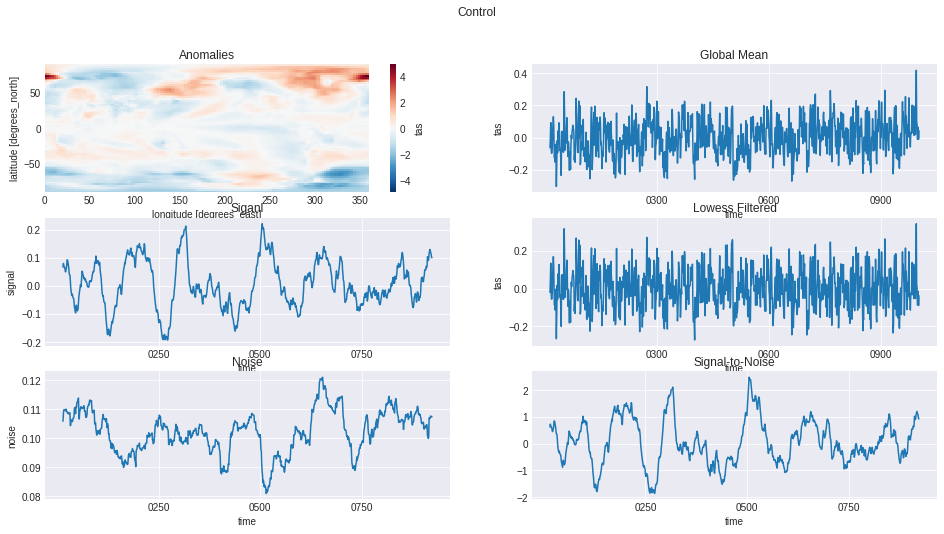

In [132]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3,ncols=2, figsize=(16,8))
control_anom.isel(time=0).plot(ax=ax1)
ax1.set_title('Anomalies')
control_anom_smean.plot(ax=ax2)
ax2.set_title('Global Mean')
control_anom_smean_signal.plot(ax=ax3)
ax3.set_title('Siganl')
control_anom_smean_loess.plot(ax=ax4)
ax4.set_title('Lowess Filtered')
control_anom_smean_noise.plot(ax=ax5)
ax5.set_title('Noise')
control_anom_smean_sn.plot(ax=ax6)
ax6.set_title('Signal-to-Noise')

fig.suptitle('Control')

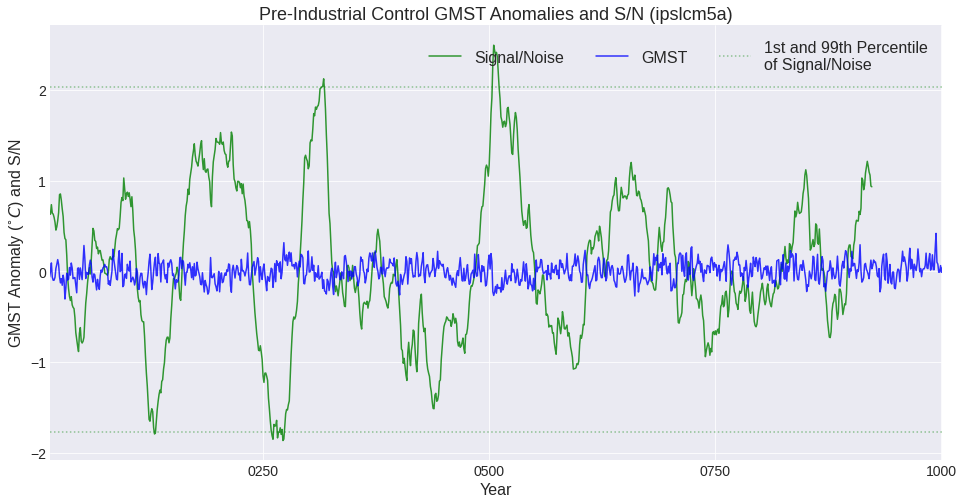

In [134]:
fig = plt.figure(figsize=(16,8))
ax = plt.gca()
control_anom_smean_sn.plot(label='Signal/Noise', ax=ax, color='green', alpha=0.8)
control_anom_smean.plot(label='GMST', ax=ax, color='blue', alpha=0.8)

time = control_anom_smean.time.values

ax.plot(time, [lbound.values] * len(control_anom_smean.time.values), 
        label='1st and 99th Percentile\nof Signal/Noise',
       c='green', linestyle =':', alpha=0.4)

ax.plot(time, [ubound.values] * len(control_anom_smean.time.values),
       c='green', linestyle =':', alpha=0.4)

ax.set_xlim(time[0], time[-1])
ax.legend(ncol=4, fontsize=16, loc='upper right')
ax.set_ylabel(r'GMST Anomaly ($^{\circ}C$) and S/N', size=16);
ax.set_xlabel('Year', size=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(f'Pre-Industrial Control GMST Anomalies and S/N ({model})', size=18)

fig.savefig(f'{IMG_DIR}/{notebook_number}_piControl_SN.png', dpi=200)

## Abrupt4x

In [135]:
sample_period_2 = (0, 200000)

Text(0.5, 1.0, 'Signal-to-Noise')

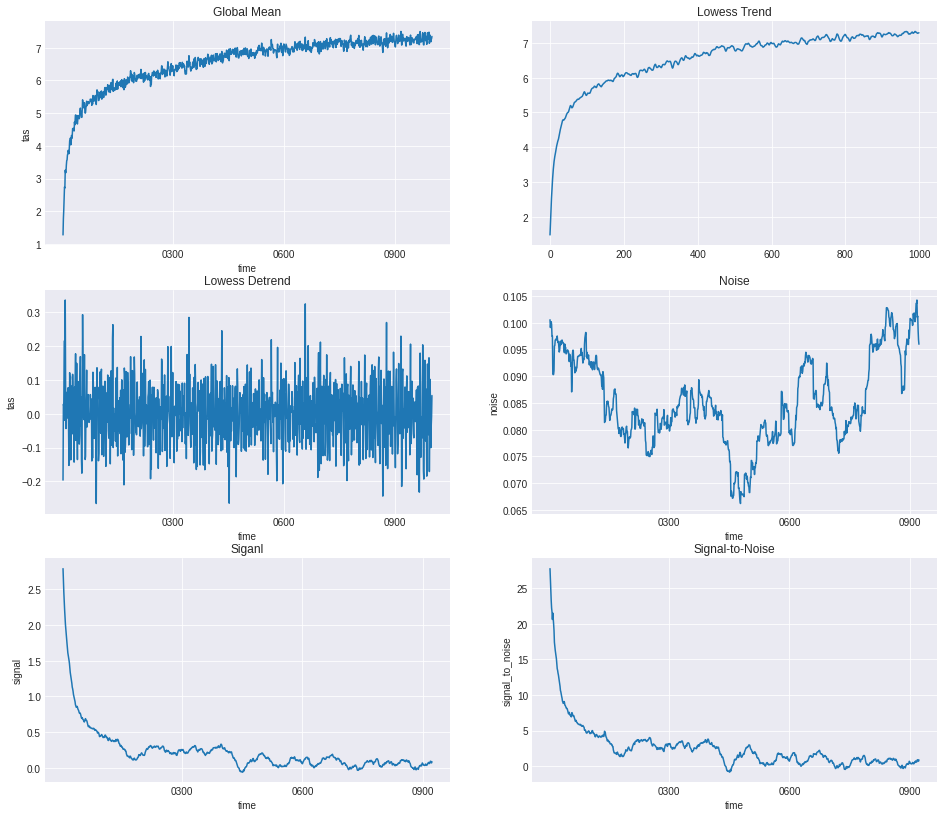

In [136]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3,ncols=2, figsize=(16,14))
abrupt_anom_smean.plot(ax=ax1)
ax1.set_title('Global Mean')
ax2.plot(yhat)
ax2.set_title('Lowess Trend')
abrupt_anom_smean_loess.plot(ax=ax3)
ax3.set_title('Lowess Detrend')
abrupt_anom_smean_noise.plot(ax=ax4)
ax4.set_title('Noise')
abrupt_anom_smean_signal.plot(ax=ax5)
ax5.set_title('Siganl')
abrupt_anom_smean_sn.signal_to_noise.plot(ax=ax6)
ax6.set_title('Signal-to-Noise')

Text(0, 0.5, 'GMST')

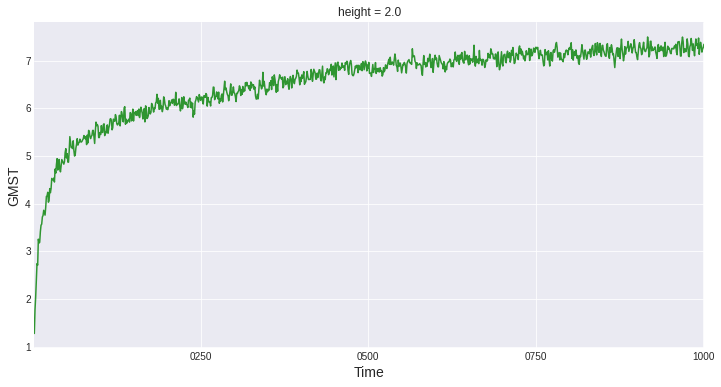

In [137]:
# A nice plot of the space mean
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
abrupt_anom_smean.plot(ax = ax, color='green', alpha = 0.8)
ax.set_xlim(abrupt_anom_smean.time.values[0], abrupt_anom_smean.time.values[-1])
ax.set_xlabel('Time', size=14)
ax.set_ylabel('GMST', size=14)
# fig.savefig(f'{IMG_DIR}/{notebook_number}_GMST.png', dpi=200)

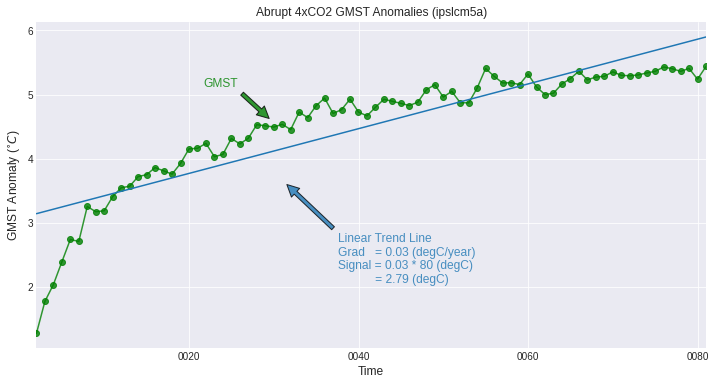

In [138]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
sample_data.plot(ax = ax, color='green', alpha = 0.8, marker='o', label='GMST')
ax.plot(sample_data.time.values, fitted_line,
        label=f'Linear Trend Line\nGrad = {gradient_sp:.2f}\nSignal {signal_sp:.2f}')
ax.set_xlim(sample_data.time.values[0], sample_data.time.values[-1])
ax.set_xlabel('Time', size=12)
ax.set_ylabel(r'GMST Anomaly ($^{\circ}C$)', size=12)
# ax.legend(ncol=2);


c_gmst = plt.gca().lines[0].get_color()
ax.annotate('GMST', xy = (0.35, 0.7), xycoords='axes fraction', size=12, c=c_gmst, alpha=0.8,
            xytext = (0.25, 0.8),
           arrowprops=dict(facecolor=c_gmst, shrink=0.05, alpha=0.8))


c_line = plt.gca().lines[1].get_color()
text = f'Linear Trend Line\nGrad   = {gradient_sp:.2f} (degC/year)\nSignal = {gradient_sp:.2f} * {window_length} (degC)\n           = {signal_sp:.2f} (degC)'
ax.annotate(text,
            xy = (0.37, 0.51), xycoords='axes fraction', size=12, c=c_line, alpha=0.8,
            xytext = (0.45, 0.2),
           arrowprops=dict(facecolor=c_line, shrink=0.05, alpha=0.8))

ax.set_title(f'Abrupt 4xCO2 GMST Anomalies ({model})');


fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_GMST_Signal.png', dpi=200)

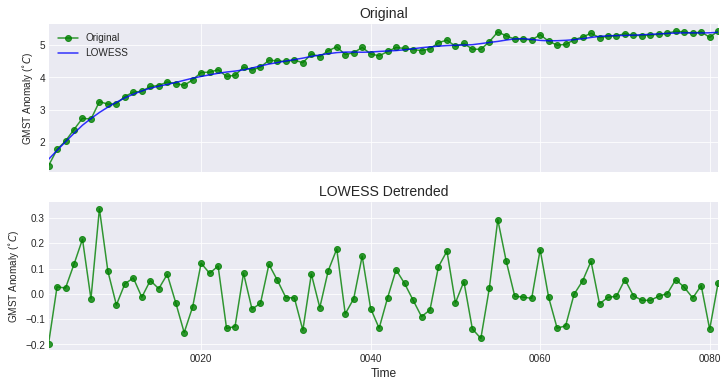

In [139]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,1,1)
abrupt_anom_smean.isel(time=slice(*sample_period)).plot(ax=ax1, label='Original', color='green', marker='o'
                                                       ,alpha=0.8)
ax1.plot(sample_data.time.values[sample_period[0]:sample_period[-1]],
         yhat[sample_period[0]:sample_period[-1]], label='LOWESS', color='blue',alpha=0.8)
# ax1.set_ylim([2.4,4])
ax1.set_title('Original', fontsize=14)
ax1.set_xlabel('')
ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax1.set_ylabel(r'GMST Anomaly ($^{\circ}C$)')
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
abrupt_anom_smean_loess.isel(time=slice(*sample_period)).plot(ax=ax2, color='green', marker='o',alpha=0.8)
# ax2.set_ylim([-0.6, 1])
ax2.set_title('LOWESS Detrended', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel(r'GMST Anomaly ($^{\circ}C$)')

ax1.set_xlim(sample_data.time.values[0], sample_data.time.values[-1]);
ax2.set_xlim(sample_data.time.values[0], sample_data.time.values[-1]);

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_GMST_lowess.png', dpi=200)

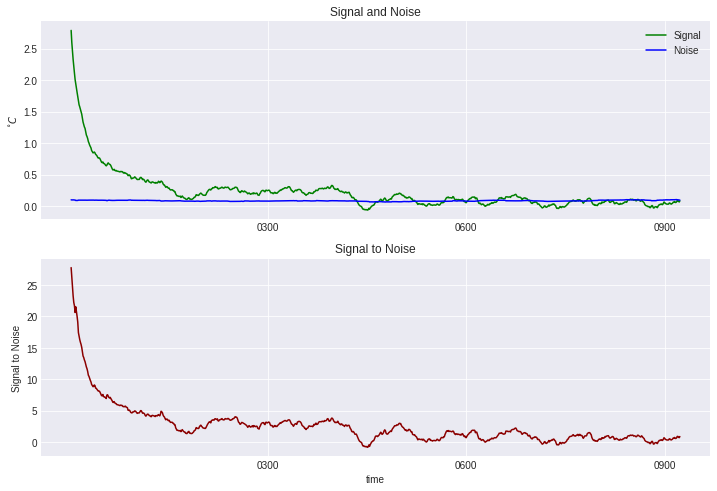

In [140]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(211)
abrupt_anom_smean_signal.isel(time=slice(*sample_period_2)).plot(ax=ax, color='green', label='Signal')
abrupt_anom_smean_noise.isel(time=slice(*sample_period_2)).plot(ax = ax, color='blue', label='Noise')
ax.set_title('Signal and Noise')
ax.set_ylabel(r'$^{\circ}C$')
ax.set_xlabel('')
ax.legend()

ax2 = fig.add_subplot(212)
abrupt_anom_smean_sn.signal_to_noise.isel(time=slice(*sample_period_2)).plot(ax = ax2, color='darkred')
ax2.set_title('Signal to Noise')
ax2.set_ylabel('Signal to Noise')

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_GMST_Signal_Npng', dpi=200)

In [141]:
bounds = {'lower': float(lbound.values), 'upper':float(ubound.values)}
bounds

{'lower': -1.7705639787139256, 'upper': 2.031472436627194}

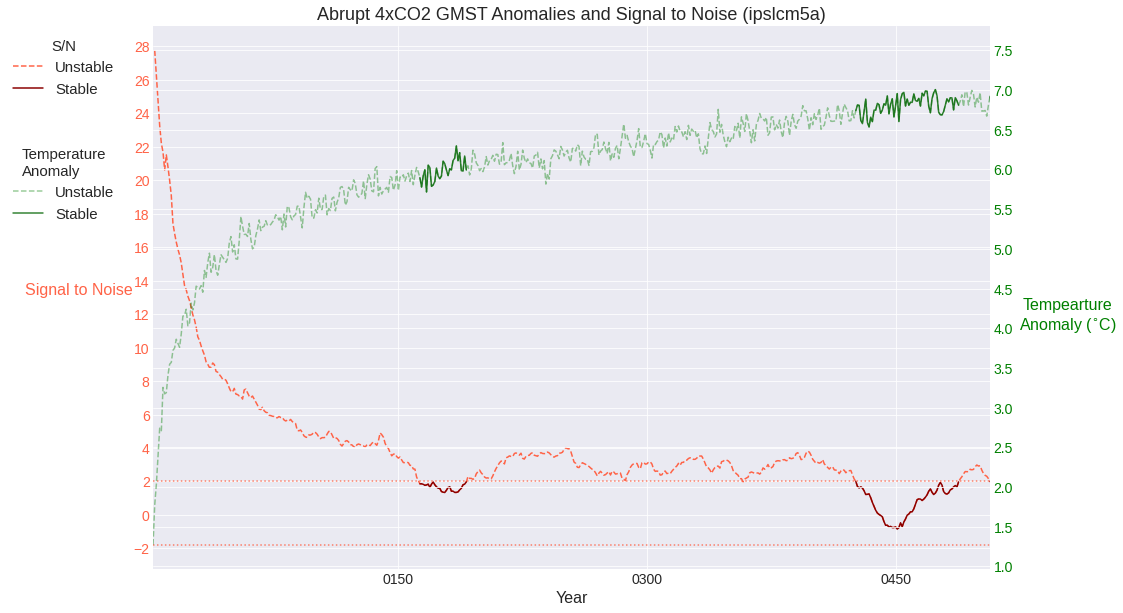

In [142]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn.signal_to_noise.squeeze(), abrupt_anom_smean,
                      temp_highlight = abrupt_stable.signal_to_noise, 
                      sn_highlight = stable_sn_da.signal_to_noise.squeeze(), 
                              bounds = bounds)

ax.set_xlim(abrupt_anom_smean_sn.time.values[0], abrupt_anom_smean_sn.time.values[505])
ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=18);

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_global_sn_temp_anomaly_t500.png',
            bbox_inches='tight', dpi=200)

In [148]:
bounds

{'lower': -1.7705639787139256, 'upper': 2.031472436627194}

In [155]:
constants.LONGRUNMIP_LENGTH

800

In [157]:
reload(sn_plotting)

<module 'sn_plotting' from '/home/563/ab2313/Documents/PhD/modules/sn_plotting.py'>

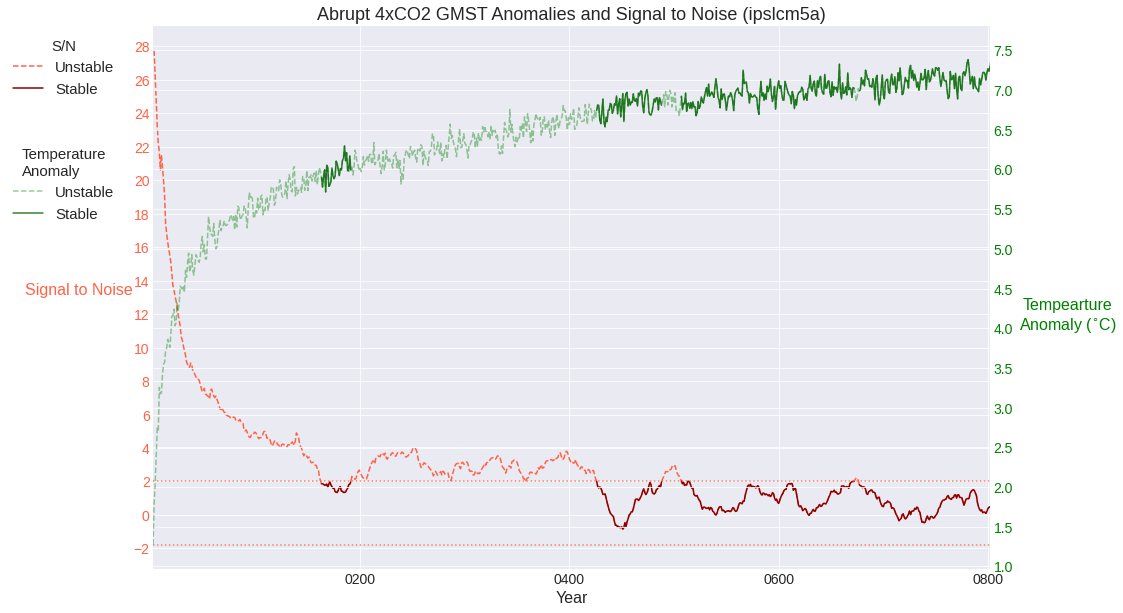

In [156]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  abrupt_anom_smean_sn.signal_to_noise.squeeze(), abrupt_anom_smean,
                      temp_highlight = abrupt_stable.signal_to_noise, 
                      sn_highlight = stable_sn_da.signal_to_noise.squeeze(), 
                              bounds = bounds)

ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=18);
ax.set_xlim(abrupt_anom_smean_sn.time.values[0], abrupt_anom_smean_sn.time.values[constants.LONGRUNMIP_LENGTH])

fig.savefig(f'{IMG_DIR}/{notebook_number}_{model}_global_sn_temp_anomaly_tmax.png',
            bbox_inches='tight', dpi=200)